# DIMENSION REDUCTION WITH AUTOENCODERS

<font size="5">*Joe Hellerstein*, Research Scientist, eScience Institute</font>

**Motivation**

We often want to reduce the dimensionality of data
* *Data Analysis*: Focus on a few important variables
* *Dynamical Systems*: Visualize dynamics (e.g., in 2d)
* *Image Processing*: Compress data into essential pixels

Dimension reduction is crucial in machine learning for simplifying complex data sets (Van Der Maaten et al. 2009), reducing computational complexity (Ray et al. 2021), and mitigating the curse of dimensionality (Talpur et al. 2023), ultimately improving model performance and interpretability. Dimension reduction encompasses two primary approaches: feature selection (Solorio-Fernández et al. 2022), which involves choosing a subset of the most informative features from the original data-set to reduce dimensionality while maintaining interpretability; and feature extraction (Li et al. 2022), a method where new, lower-dimensional features are derived from the original data to capture essential patterns and relationships.

Autoencoders and their applications in machine learning: a survey  Kamal Berahmand1 · Fatemeh Daneshfar2 · Elaheh Sadat Salehi3 · Yuefeng Li1 · Yue Xu1, Artificial Intelligence Review (2024)

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/feature_extraction.png" 
         alt="Types of feature extractiom."
         width="600">

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/generic_autoencoder.png" 
         alt="Generic autoencoder"
         width="400">

* Same number of nodes in the input and output layers
* Hidden layer has fewer nodes
* May be many hidden layers.
* If many hidden layers.
* * An even number. First half is **encoder**; second is **decoder**

We will focus on the task of compression initially. And then show the benefits of autoencoders for noise reduction.

# Preliminaries

In [1]:
import collections
import inspect
import io
try:
    import ipynbname
except:
    !pip install ipynbname
    import ipynbname
try:
    from deepdiff import DeepDiff
except:
    !pip install deepdiff  # Used in related code
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import sys
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA # type:ignore
from sklearn.preprocessing import StandardScaler # type:ignore
from typing import Tuple, List, Optional
from torchvision import datasets
import zipfile

# Helpers

## Paths

The helpers make use of the pixel_proficiency github repository. To do this, we clone the repository and update the PYTHONPATH to use code in the repository.

In [2]:
# Clone the repository and make sure it's current
if os.path.isdir("pixel_proficiency"):
    !rm -rf pixel_proficiency
!git clone https://github.com/joseph-hellerstein/pixel_proficiency.git

Cloning into 'pixel_proficiency'...
remote: Enumerating objects: 464, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 464 (delta 0), reused 3 (delta 0), pack-reused 458 (from 2)
Receiving objects: 100% (464/464), 128.30 MiB | 10.30 MiB/s, done.
Resolving deltas: 100% (272/272), done.
Encountered 2 files that should have been pointers, but weren't:
	experiments/animals_dense/animals_encode_dims-27648__512__128__16__activation-sigmoid__dropout_rate-0.4__batch_size-128__autoencoder-DenseAutoencoder_decoder.keras
	experiments/animals_dense/animals_encode_dims-27648__512__128__16__activation-sigmoid__dropout_rate-0.4__batch_size-128__autoencoder-DenseAutoencoder_encoder.keras


In [3]:
# Move the src directory
if os.path.isdir("src"):
    !rm -rf src
!mv pixel_proficiency/src .

In [4]:
NOTEBOOK_PATH = os.getcwd()
SRC_PATH = os.path.join(NOTEBOOK_PATH, "src")
sys.path.insert(0, SRC_PATH)
# Serialized experiments
PROJECT_PATH = os.path.dirname(NOTEBOOK_PATH)
EXPERIMENTS_PATH = os.path.join(NOTEBOOK_PATH, "pixel_proficiency", "experiments")
PATH_DAE_MNIST = os.path.join(EXPERIMENTS_PATH, "mnist_dense",
        "mnist_encode_dims-784__128__64__16__activation-sigmoid__dropout_rate-0.4__batch_size-128__autoencoder-DenseAutoencoder")
PATH_CAE_MNIST = os.path.join(EXPERIMENTS_PATH, "mnist_convolutional",
        "mnist_image_shape-28__28__1__filter_sizes-128__64__16__activation-sigmoid__dropout_rate-0.4__batch_size-128__autoencoder-ConvolutionalAutoencoder")
PATH_DAE_ANIMALS = os.path.join(EXPERIMENTS_PATH, "animals_dense",
        "animals_encode_dims-27648__512__128__16__activation-sigmoid__dropout_rate-0.4__batch_size-128__autoencoder-DenseAutoencoder")
PATH_CAE_ANIMALS = os.path.join(EXPERIMENTS_PATH, "animals_convolutional",
        "animals_image_shape-96__96__3__filter_sizes-256__128__64__batch_size-128__autoencoder-ConvolutionalAutoencoder")

## Constants

In [5]:
import src.constants as cn
cn.ANIMALS_PATH = "animals.pkl"
cn.MNIST_PATH = "mnist.pkl"
cn.MODEL_DIR = "."

In [6]:
TrainTestData = collections.namedtuple('TrainTestData', ['x_train', 'label_train', 'x_test', 'label_test', 'class_names'])
# x_train: np.ndarray (training data)
# label_train: np.ndarray (training labels)
# x_test: np.ndarray (test data)
# label_test: np.ndarray (test labels)
# class_names: List[str] (class names)

## getPklAnimals

In [7]:
from src.util import getPklAnimals
print(inspect.getsource(getPklAnimals))

def getPklAnimals(is_verbose: bool = False) -> TrainTestData:
    """Recovers Animals image data from pickle files, or pickles the data if not present.

    Returns:
        TrainTestData: A named tuple containing training and test data and labels.
    """
    ##
    data_dir = os.path.join(cn.DATA_DIR, 'animals')
    def getData(data_type: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
        dataset = datasets.STL10(root=data_dir, split=data_type, download=True)
        class_names = dataset.classes  # List of class names
        images = []
        labels = []
        for img, label in dataset:
            images.append(np.array(img))
            labels.append(label)
        images_array = np.stack(images)  # Shape: (N, 96, 96, 3)
        labels_array = np.array(labels)  # Shape: (N,)
        return images_array, labels_array, class_names
    ##
    if not os.path.exists(cn.ANIMALS_PATH):
        if is_verbose:
            print("***Pickling Animals data...")
        train_image

In [8]:
X_ANIMALS_TRAIN, LABEL_ANIMALS_TRAIN, X_ANIMALS_TEST, LABEL_ANIMALS_TEST, ANIMALS_CLASS_NAMES = getPklAnimals()

In [9]:
np.shape(X_ANIMALS_TRAIN)

(5000, 96, 96, 3)

In [10]:
ANIMALS_IMAGE_SHAPE = list(np.shape(X_ANIMALS_TRAIN)[1:])
ANIMALS_IMAGE_SHAPE

[96, 96, 3]

## getPklMNIST

In [11]:
from src.util import getPklMNIST
print(inspect.getsource(getPklMNIST))

def getPklMNIST(is_verbose: bool = False) -> TrainTestData:
    """Recovers MNIST image data from pickle files, or pickles the data if not present.

    Returns:
        TrainTestData: A named tuple containing training and test data and labels.
    """
    if not os.path.exists(cn.MNIST_PATH):
        if is_verbose:
            print("***Pickling MNIST data...")
        (x_train, label_train), (x_test, label_test) = mnist.load_data()
        data = (x_train, label_train, x_test, label_test)
        with open(cn.MNIST_PATH, 'wb') as f:
            pickle.dump(data, f)
    else:
        if is_verbose:
            print("***Unpickling MNIST data...")
        with open(cn.MNIST_PATH, 'rb') as f:
            x_train, label_train, x_test, label_test = pickle.load(f)
    class_names = [str(i) for i in range(10)]
    return TrainTestData(x_train, label_train, x_test, label_test, class_names)



In [12]:
X_MNIST_TRAIN, LABEL_MNIST_TRAIN, X_MNIST_TEST, LABEL_MNIST_TEST, MNIST_CLASS_NAMES = getPklMNIST()

In [13]:
np.shape(X_MNIST_TRAIN)

(60000, 28, 28)

In [14]:
MNIST_IMAGE_SHAPE = list(np.shape(X_MNIST_TRAIN)[1:])
MNIST_IMAGE_SHAPE

[28, 28]

## visualize

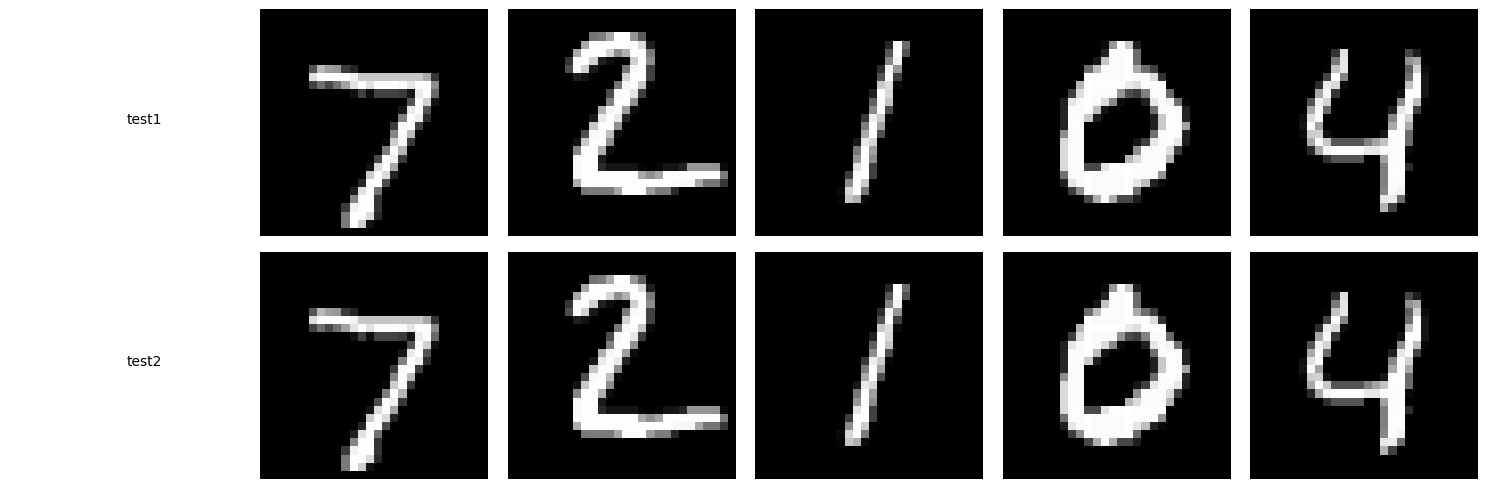

OK!


In [15]:
def visualize(arrs: np.ndarray, num_image: int, titles: str = "", figsize=(15, 5)):
    # Displays one or more digits
    num_row = len(arrs)
    _, axes =  plt.subplots(num_row, num_image + 1, figsize=figsize)
    for irow, arr in enumerate(arrs):
        ax = axes[irow, 0]
        ax.text(0.5, 0.5, titles[irow])
        ax.axis('off')
        for i in range(num_image):
            # Original images
            #ax = plt.subplot(1, num_image + 1, i + 2)
            ax = axes[irow, i+1]
            ax.imshow(arr[i].reshape(28, 28), cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Test
visualize([X_MNIST_TEST, X_MNIST_TEST], 5, titles=["test1", "test2"])
#plt.close()
print("OK!")

## zipCompressArray

In [16]:
# Method 1: Using BytesIO with zipfile
def zipCompressArray(arr):
    """Compress numpy array to zip in memory"""
    # Create in-memory bytes buffer
    zip_buffer = io.BytesIO()
    
    # Create zip file in memory
    with zipfile.ZipFile(zip_buffer, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        # Save array to bytes
        arr_bytes = io.BytesIO()
        np.save(arr_bytes, arr)
        arr_bytes.seek(0)
        
        # Write to zip
        zip_file.writestr('array.npy', arr_bytes.read())
    
    # Get compressed data
    zip_buffer.seek(0)
    return zip_buffer

# Test
arr = np.random.rand(1000, 1000)
compressed = zipCompressArray(arr)
assert(len(compressed.getvalue()) < arr.nbytes)
print("OK!")

OK!


## dictToStr

In [17]:
from src.util import dictToStr
print(inspect.getsource(dictToStr))

def dictToStr(dct: dict)->str:
    result = ""
    sep = ""
    for key, value in dct.items():
        if len(result) > 0:
            sep = "-"
        result = result + sep + key + "_" + str(value)
    return result



## AbstractAutoencoder

In [18]:
from src.abstract_autoencoder import AbstractAutoencoder
print(inspect.getsource(AbstractAutoencoder))

class AbstractAutoencoder(object):
    ExperimentResult = collections.namedtuple('ExperimentResult',
            ['batch_size', 'history', 'base_path', 'context_str', 'autoencoder'])

    def __init__(self,
            image_shape: Union[Tuple[int], List[int]],
            base_path: str,
            is_delete_serialization: bool=True,
            activation: str='sigmoid',
            is_early_stopping: bool = True,
            is_verbose: bool = False,
            dropout_rate: float=0.4,
            batch_size: int = 128,
            ):
        """Initializes the abstract autoencoder.
        Args:
            base_path (str): Base path for model serialization.
            is_delete_serializations (bool, optional): Whether to delete existing serializations. Defaults to True.
            self.activation (str, optional): Activation function to use in the model. Defaults to 'sigmoid'.
            is_early_stopping (bool, optional): Whether to use early stopping during training. Default

## DenseAutoencoder

In [19]:
from src.dense_autoencoder import DenseAutoencoder
print(inspect.getsource(DenseAutoencoder))

class DenseAutoencoder(AbstractAutoencoder):
    def __init__(self,
            image_shape: Optional[Union[Tuple[int], List[int]]]=None,
            encode_dims: Optional[List[int]]=None,
            base_path: str=cn.EXPERIMENT_DIR,
            is_delete_serialization: bool=True,
            activation: str='sigmoid',
            is_early_stopping: bool = True,
            is_verbose: bool = False,
            dropout_rate: float = 0.4):
        """Initialize the dense autoencoder.

        Args:
            image_shape (Union[Tuple[int], List[int]]): Shape of the input images (height, width, channels)
            encode_dims (List[int]): List of integers representing the dimensions of the encoding layers.
                If the first element does not match the flattened image size, it will be prepended.
            base_path (str, optional): Base path for model serialization. Defaults to BASE_PATH.
            is_delete_serializations (bool, optional): Whether to delete existing ser

Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3198
Epoch 1: val_loss improved from None to 0.26085, saving model to /Users/jlheller/home/Technical/repos/pixel_proficiency/experiments/best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2771 - val_loss: 0.2609 - learning_rate: 0.0010
Epoch 2/2
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2599
Epoch 2: val_loss improved from 0.26085 to 0.24969, saving model to /Users/jlheller/home/Technical/repos/pixel_proficiency/experiments/best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2579 - val_loss: 0.2497 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 660,962 (2.52 MB)

 Trainable params: 220,320 (860.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 440,642 (1.68 MB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


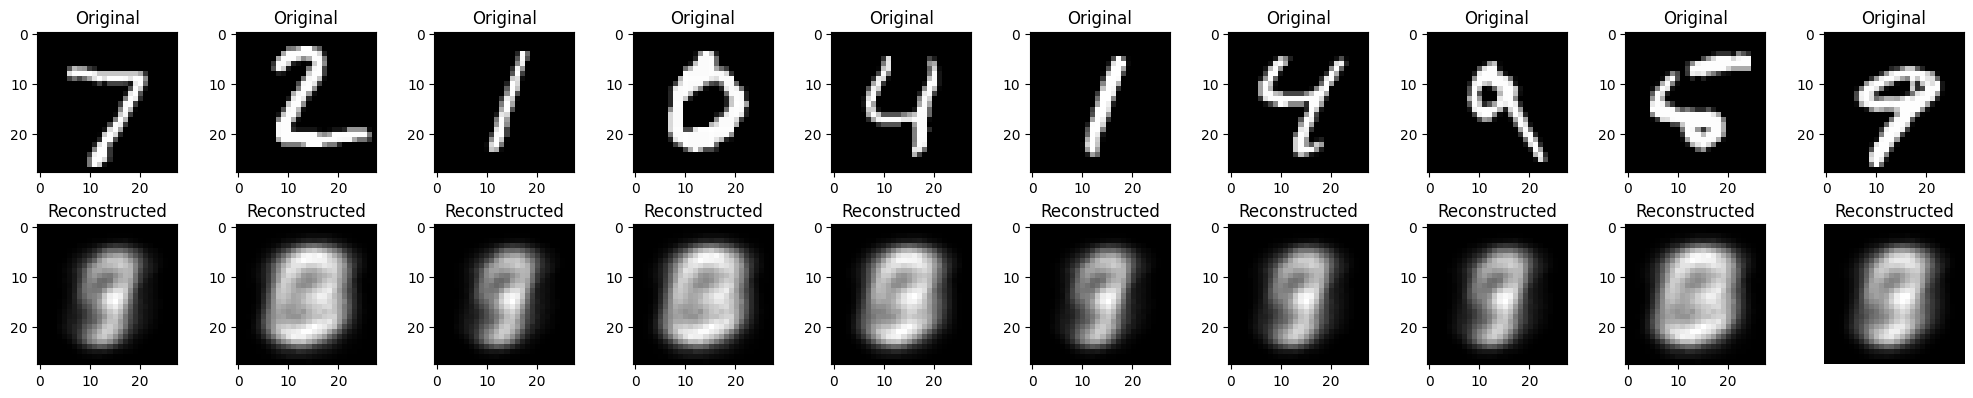

OK!


In [20]:
# Tests
encode_dims = [128, 64, 16]
dae = DenseAutoencoder(image_shape=MNIST_IMAGE_SHAPE, encode_dims=encode_dims, is_delete_serialization=True)
dae.fit(X_MNIST_TRAIN, num_epoch=2, batch_size=128, validation_data=X_MNIST_TEST, is_verbose=1)
dae.summarize()
dae.plot(X_MNIST_TEST)
print("OK!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


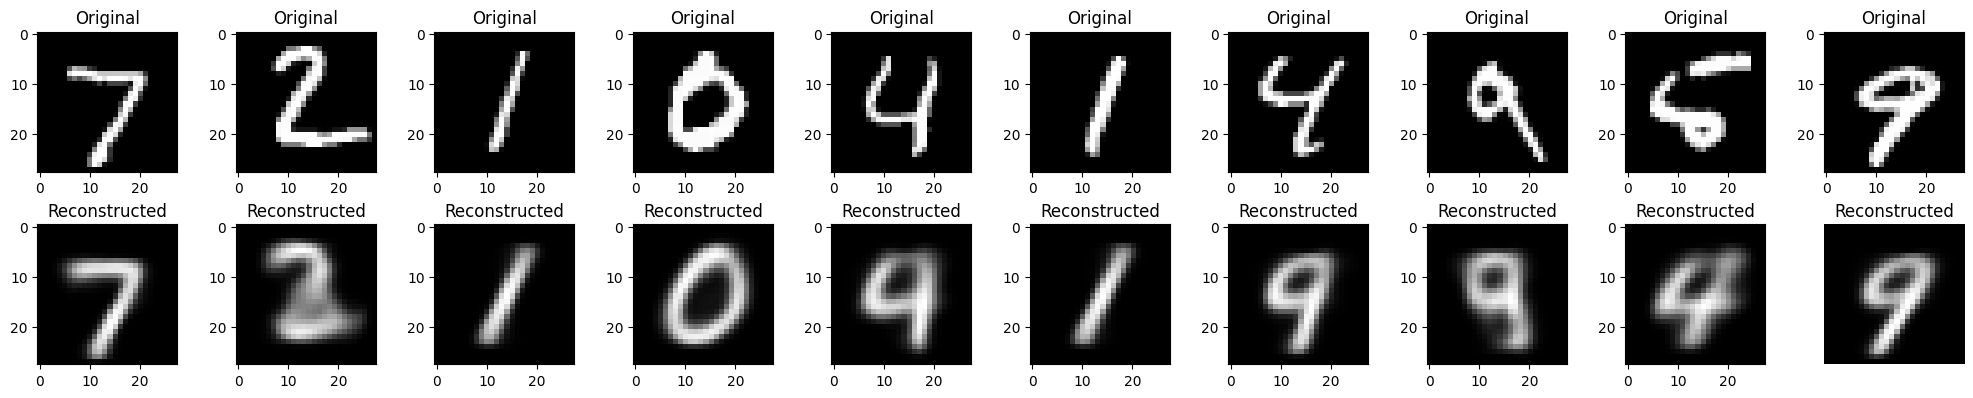

In [21]:
# Serialized model trained on 1,000 epochs
DAE_MNIST = DenseAutoencoder.deserialize(PATH_DAE_MNIST)
DAE_MNIST.plot(X_MNIST_TEST)

## Convolutional Autoencoder

In [22]:
from src.convolutional_autoencoder import ConvolutionalAutoencoder
print(inspect.getsource(ConvolutionalAutoencoder))

class ConvolutionalAutoencoder(AbstractAutoencoder):

    def __init__(self,
            image_shape: Optional[Union[Tuple[int], List[int]]]=None,
            filter_sizes: Optional[List[int]] = None,
            base_path: str=cn.EXPERIMENT_DIR,
            is_delete_serialization: bool=True,
            activation: str='sigmoid',
            is_early_stopping: bool = True,
            is_verbose: bool = False,
            dropout_rate: float = 0.4):
        """Initializes the convolutional autoencoder.

        Args:
            image_shape (List[int]): Shape of the input images (height, width, channels)
            filter_sizes (List[int]): dimensions of the filters. Last one is the filter for the bottleneck
            base_path (str, optional): Base path for model serialization. Defaults to BASE_PATH.
            is_delete_serializations (bool, optional): Whether to delete existing serializations. Defaults to
            activation (str, optional): Activation function to use in th

 21/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step 

/Users/jlheller/home/Technical/repos/pixel_proficiency/pix/lib/python3.10/site-packages/keras/src/backend/common/backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


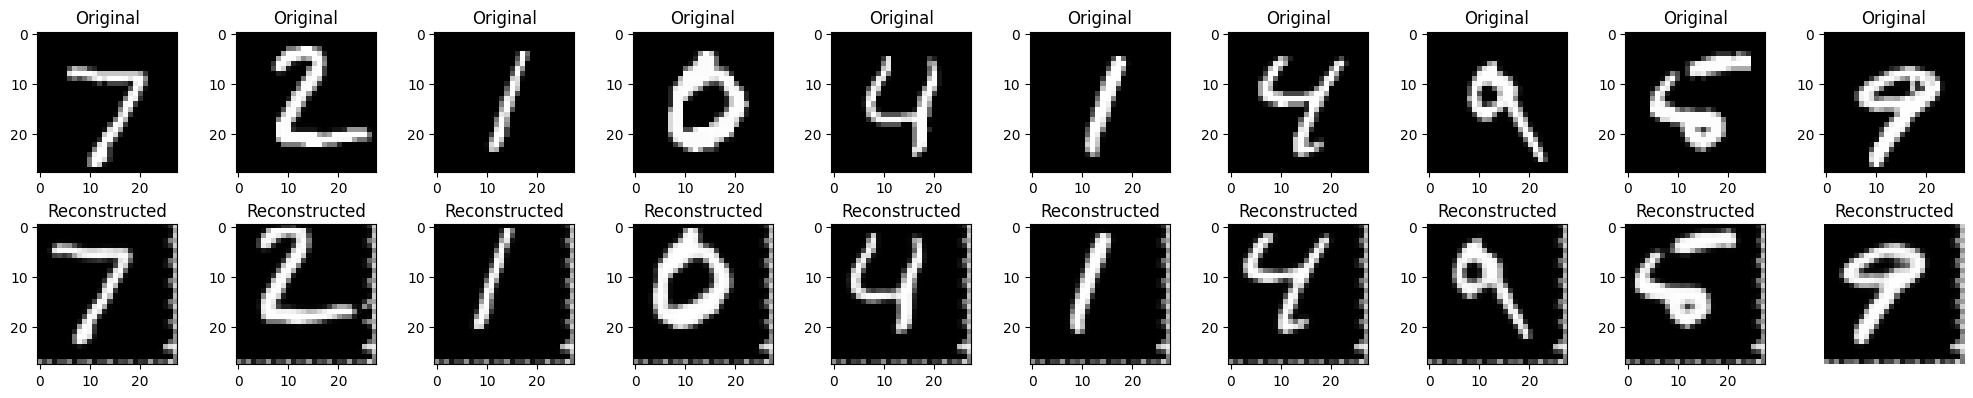

In [23]:
# Serialized model trained on 1,000 epochs
CAE_MNIST = ConvolutionalAutoencoder.deserialize(PATH_CAE_MNIST)
CAE_MNIST.plot(X_MNIST_TEST)

# Data Preparation

In [24]:
X_MNIST_TRAIN_FLAT = X_MNIST_TRAIN.reshape((len(X_MNIST_TRAIN), 28 * 28))
X_MNIST_TEST_FLAT = X_MNIST_TEST.reshape((len(X_MNIST_TEST), 28 * 28))
np.shape(X_MNIST_TRAIN_FLAT), np.shape(X_MNIST_TEST_FLAT)

((60000, 784), (10000, 784))

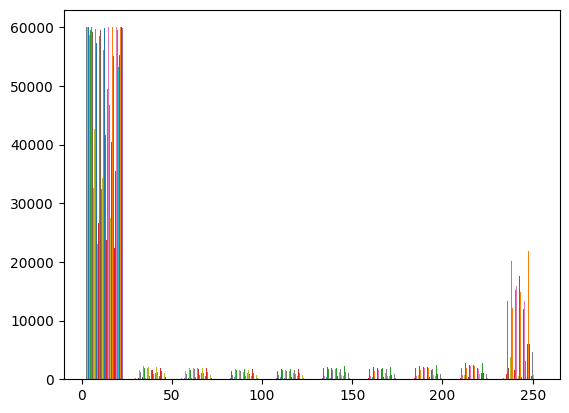

In [25]:
_ = plt.hist(X_MNIST_TRAIN_FLAT)

# zip compression

zip compression is lossless. It is achieved by clever encoding of the data: Use the shortest encodings for values that occur most frequently.

In [26]:
compressed = zipCompressArray(X_MNIST_TRAIN_FLAT)  # See Helpers for this function
num_uncompressed_mbyte = X_MNIST_TRAIN_FLAT.nbytes/1e6
num_compressed_mbyte = len(compressed.getvalue())/1e6
print(f"Uncompressed size of MNIST training data: {num_uncompressed_mbyte} MB")
print(f"Compressed size of MNIST training data: {num_compressed_mbyte} MB")
print(f"Compression ratio: {num_uncompressed_mbyte/num_compressed_mbyte}")

Uncompressed size of MNIST training data: 47.04 MB
Compressed size of MNIST training data: 9.822183 MB
Compression ratio: 4.789159395625188


***Lossless compression provides a lower bound for dimension reduction.***

# Principal Component

* Lossy compression by extracting dominant effects
* Assumes linearity


<img src="https://www.spectroscopyworld.com/sites/default/files/articles/TD_16_6-w.jpg" 
         alt=""
         width="400">

<img src="https://i.ytimg.com/vi/L18Cd89kMRg/maxresdefault.jpg" 
         alt=""
         width="800">

In [27]:
def generatePCA(arr: np.ndarray, n_component: int) -> Tuple[np.ndarray, str]:
    pca = PCA(n_components=n_component, random_state=42)
    pca.fit(arr)
    x_reduced = pca.transform(arr)
    x_decoded = pca.inverse_transform(x_reduced)
    title = f"PCA/{n_component}"
    return x_decoded, title

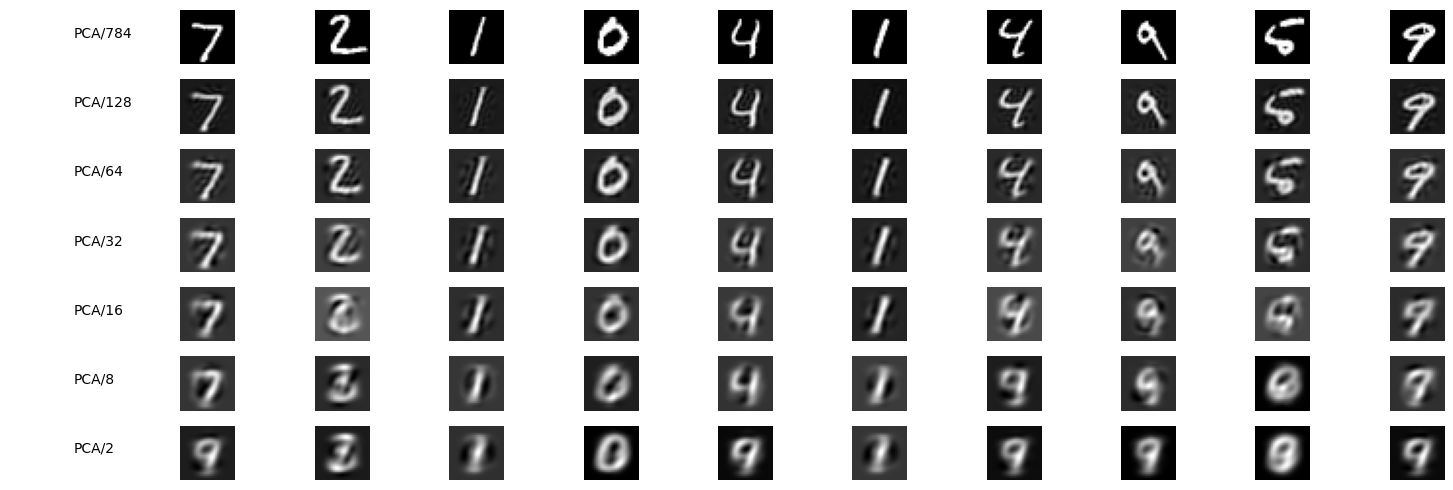

Compression ratios
784: 1.0
128: 6.125
64: 12.25
32: 24.5
16: 49.0
8: 98.0
2: 392.0


In [28]:
sizes = [28*28, 128, 64, 32, 16, 8, 2]
results = [generatePCA(X_MNIST_TEST_FLAT, n) for n in sizes]
arrs = [r[0] for r in results]
titles = [r[1] for r in results]
visualize(arrs, 10, titles=titles)
#
print("Compression ratios")
for size in sizes:
    print(f"{size}: {784/size}")

# Dense Autoencoder

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/generic_autoencoder.png" 
         alt="Generic autoencoder"
         width="400">

## Data preparation

In [29]:
X_MNIST_TRAIN[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [30]:
np.max(X_MNIST_TRAIN), np.max(X_MNIST_TEST)

(np.uint8(255), np.uint8(255))

## Implementation

Consider the MNIST data with 28 by 28 pixels in shades of grey. We input an image as an array ``input_img`` with
shape ``(28, 28)``. A ``Tensor`` is output for each layer.
* We define two networks: an encoder network and a decoder network
* The first encoder layer must flatten the image.
  
    ``encoded = layers.Flatten()(input_img)``
* The second layer must have a count of neurons equal to the flattened image

    ``encoded = layers.Dense(784, activation=self.activation)(encoded)``
* Subsequent encoder layers are specified by the number of neurons. The number of neurons should decrease

    ``encoded = layers.Dense(128, activation=self.activation)(encoded)``
  
    ``encoded = layers.Dense(64, activation=self.activation)(encoded)``
  
    ``encoded = layers.Dense(16, activation=self.activation)(encoded)``

* The final layer of the encoder is the **bottneck layer**. This determines the dimension reduction of the Autoencoder.


The decoder is usually specified by inverting what was done in the encoder. We start by defining the first decoder layer is defined in terms of the bottleneck ``Tensor``.
    
    ``decoded = layers.Dense(64, activation=self.activation)(encoded)``
* Subsequent layers reverse what was done in the encoder.

    ``decoder = layers.Dense(128, activation=self.activation)(decoder)``
  
    ``decoder = layers.Dense(784, activation=self.activation)(decoder)``

     ``decoder = layer.Reshape((28, 28))(decoder)``

We can add dropouts to each layer to obtain a more sparese decoder.

In [31]:
# A Dense Autoencoder for the MNIST Data
encode_dims = [784, 128, 64, 16]
DAE = DenseAutoencoder(image_shape=MNIST_IMAGE_SHAPE, encode_dims=encode_dims, is_verbose=True)
DAE.summarize()
print(f"Compression factor: {DAE.compression_factor}")

[DenseAutoencoder] ...deleting existing serializations (if any) and rebuilding the model.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 784)            │       101,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,320 (860.62 KB)

 Trainable params: 220,320 (860.62 KB)

 Non-trainable params: 0 (0.00 B)

Compression factor: 49.0


## Evaluation

Autoencoding is a kind of regression problem.

Epoch 1/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3197
Epoch 1: val_loss improved from None to 0.26049, saving model to /Users/jlheller/home/Technical/repos/pixel_proficiency/experiments/best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2769 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2593
Epoch 2: val_loss improved from 0.26049 to 0.24692, saving model to /Users/jlheller/home/Technical/repos/pixel_proficiency/experiments/best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2565 - val_loss: 0.2469 - learning_rate: 0.0010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2462
Epoch 3: val_loss improved from 0.24692 to 0.24102, saving model to /Users/jlheller/home/Technical/repos/pixel_proficiency/experiments/best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2449 - val_loss: 0.2410 - learning_rate: 0.0010
Epoch 4/10
468/469 ━━━━━━━

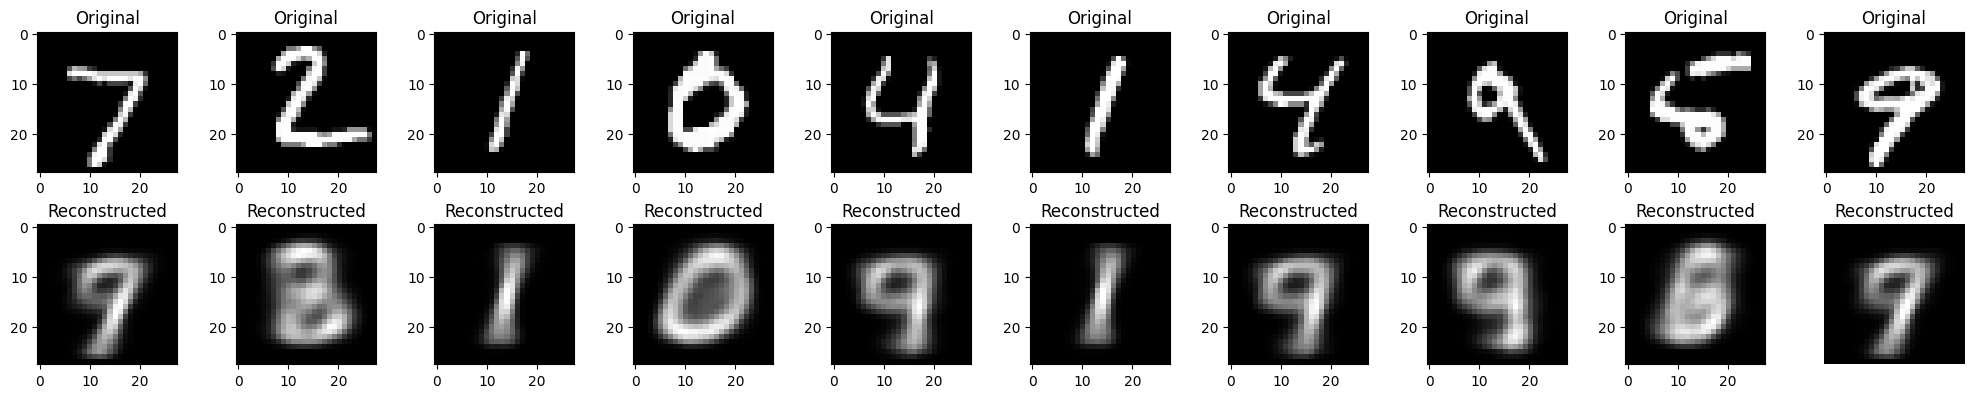

In [32]:
DAE.fit(X_MNIST_TRAIN, num_epoch=10, batch_size=128, validation_data=X_MNIST_TEST, is_verbose=1)
DAE.plot(X_MNIST_TEST)

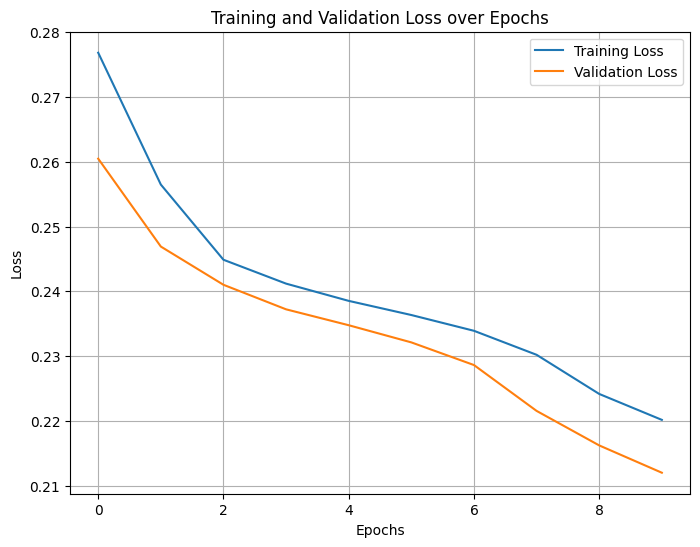

In [33]:
DAE.plotLoss()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


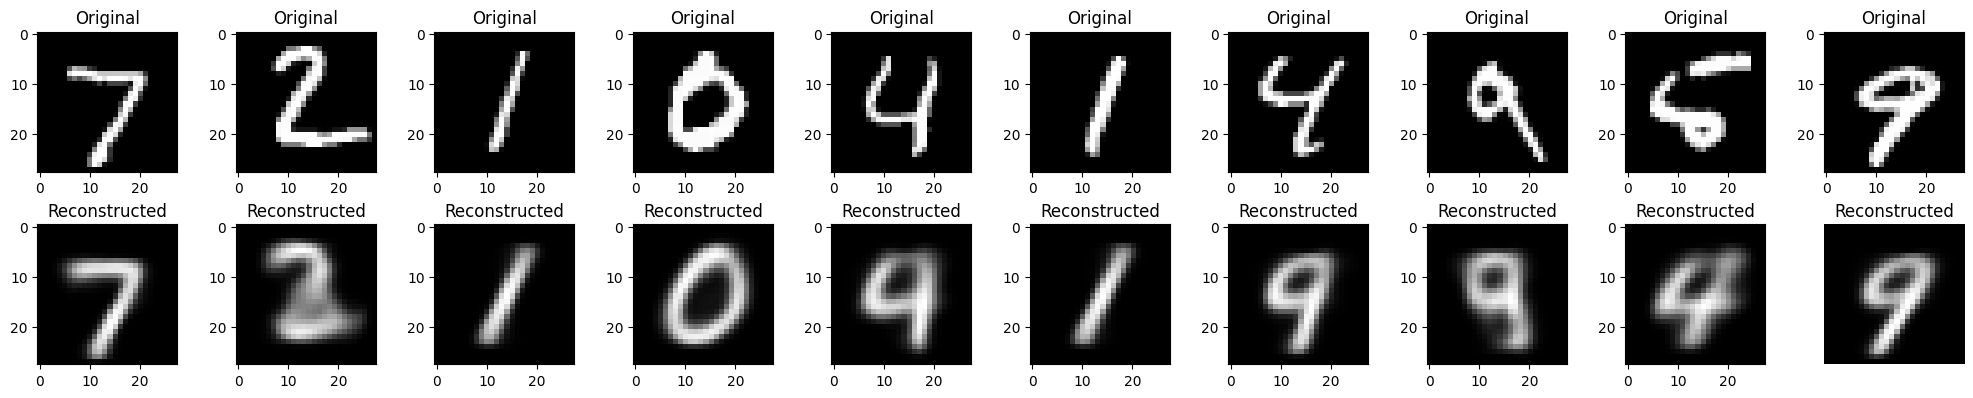

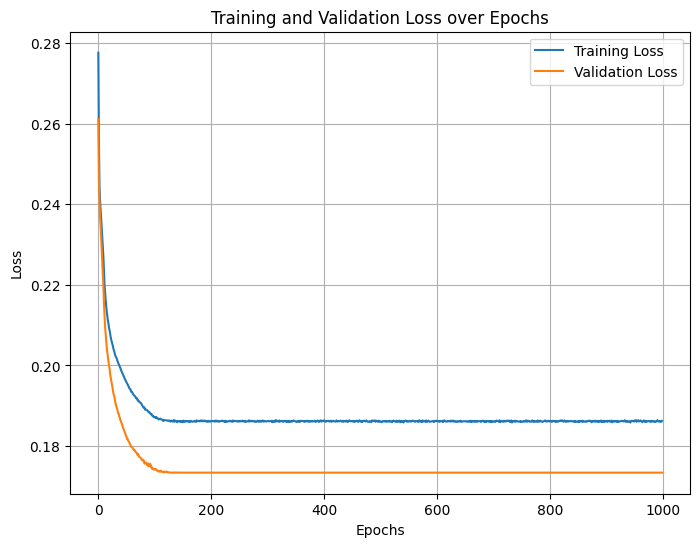

In [34]:
# Training on 1,000 epochs
DAE_MNIST.plot(X_MNIST_TEST)
DAE_MNIST.plotLoss()

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/dense_autoencoder-epochs_100-MNIST.png" 
         alt="Generic autoencoder"
         width="1200">

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


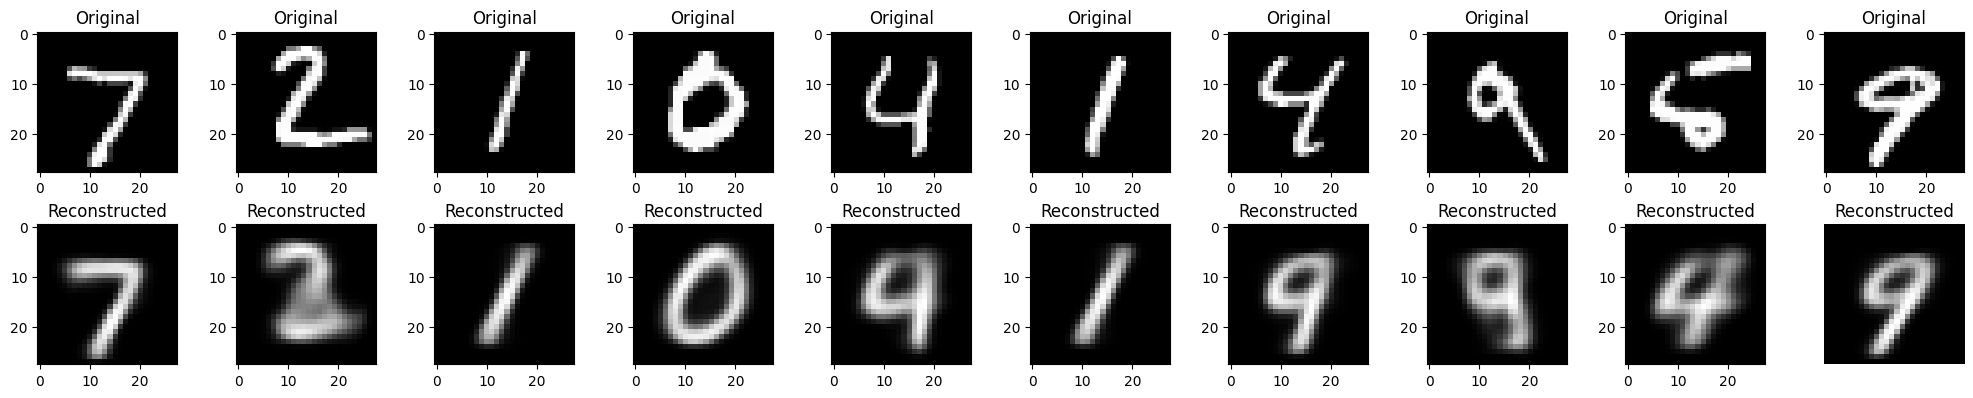

In [35]:
dae1 = DenseAutoencoder.deserialize(PATH_DAE_MNIST)
dae1.plot(X_MNIST_TEST)

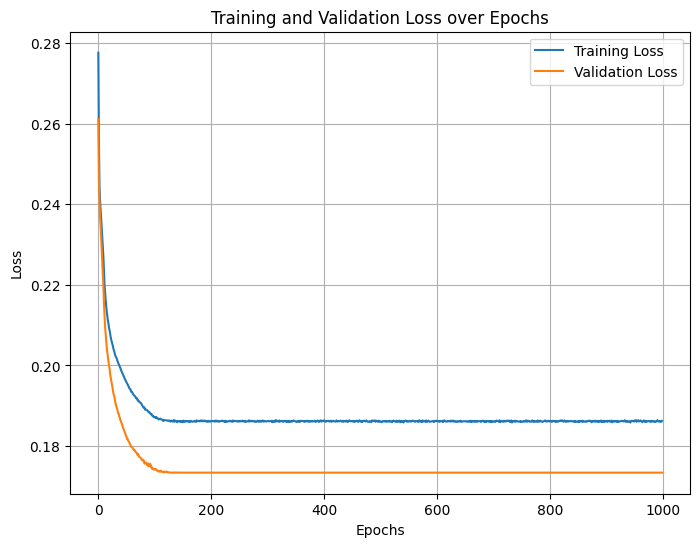

In [36]:
dae1.plotLoss()

# Convolutional Autoencoder

**Illustration of a Convolutional Autoencoder**

<img src="https://raw.githubusercontent.com/joseph-hellerstein/pixel_proficiency/main/docs/images/convolutional_autoencoder.png" 
         alt="Convolutional autoencoder"
         width="800">

**Elements of this architecture**
* Alternates ``Conv2D`` with ``MaxPooling2D``

**Conv2DTranspose**

Conv2DTranspose is a layer that performs transposed convolution (also called deconvolution or fractional-strided convolution). It's essentially the reverse operation of a regular convolution - it upsamples the input spatial dimensions.

While regular Conv2D reduces spatial dimensions (or keeps them the same), Conv2DTranspose increases them:
* Conv2D:          64×64 → 32×32  (downsampling)
* Conv2DTranspose: 32×32 → 64×64  (upsampling)
The operation inserts zeros between input pixels and then applies a regular convolution, effectively "spreading out" the information.

## Data preparation

Same concerns as for a dense autoencoder

## Implementation

In [37]:
CAE = ConvolutionalAutoencoder(image_shape=MNIST_IMAGE_SHAPE,
        filter_sizes=[256, 128, 64],
        is_delete_serialization=True, is_verbose=True)
CAE.summarize()

[ConvolutionalAutoencoder] ...deleting existing serializations (if any) and rebuilding the model.


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │         2,305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 742,721 (2.83 MB)

 Trainable params: 742,721 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

## Evaluation

In [38]:
CAE.fit(X_MNIST_TRAIN, num_epoch=1, batch_size=128, validation_data=X_MNIST_TEST,
                is_verbose=True)

Epoch 1/2
  1/469 ━━━━━━━━━━━━━━━━━━━━ 1:23 178ms/step - loss: 0.2047 - mae: 0.4438

/Users/jlheller/home/Technical/repos/pixel_proficiency/pix/lib/python3.10/site-packages/keras/src/backend/common/backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.1055 - mae: 0.1467
Epoch 1: val_loss improved from None to 0.05963, saving model to /Users/jlheller/home/Technical/repos/pixel_proficiency/experiments/best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 0.0889 - mae: 0.1502 - val_loss: 0.0596 - val_mae: 0.1531 - learning_rate: 0.0010
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0491 - mae: 0.1201
Epoch 2: val_loss improved from 0.05963 to 0.03857, saving model to /Users/jlheller/home/Technical/repos/pixel_proficiency/experiments/best_autoencoder.keras
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 88ms/step - loss: 0.0437 - mae: 0.1071 - val_loss: 0.0386 - val_mae: 0.0870 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


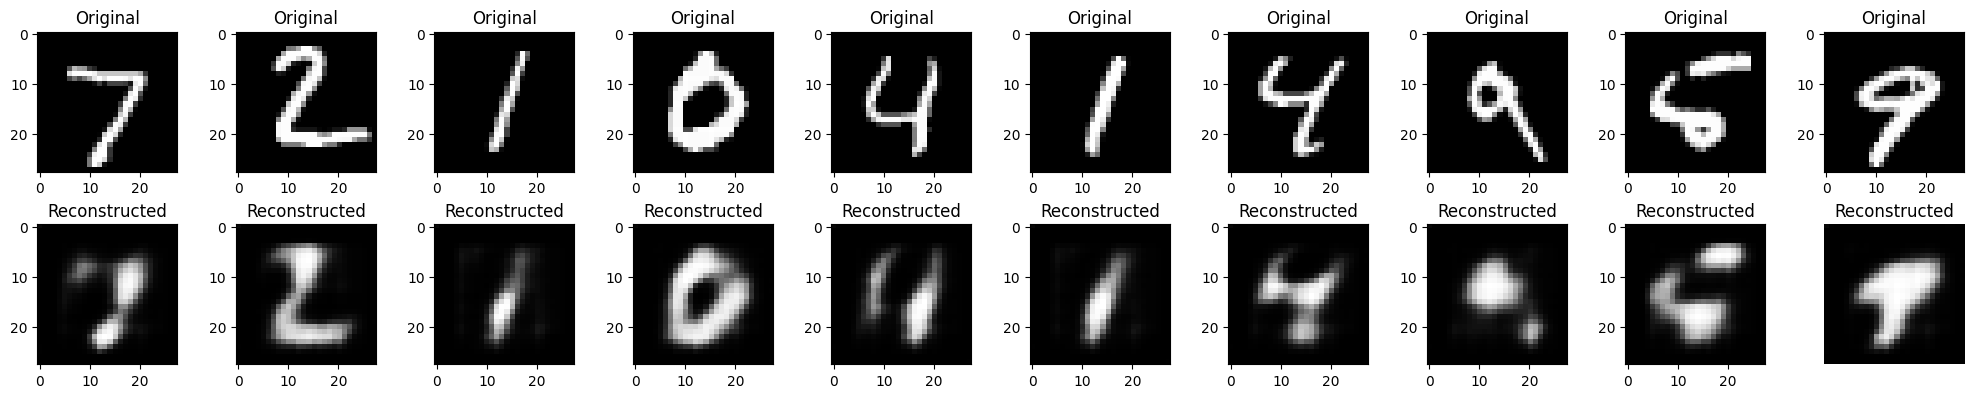

In [39]:
CAE.plot(X_MNIST_TEST)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


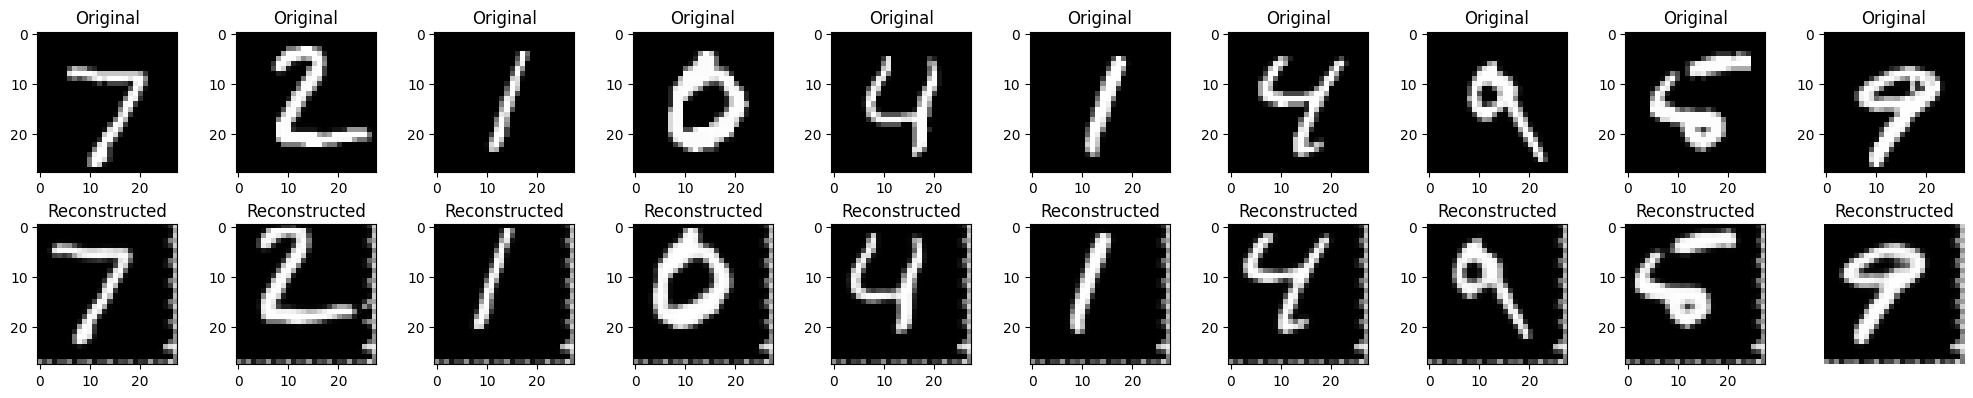

In [40]:
# Trained on 1,0000 epochs
CAE_MNIST.plot(X_MNIST_TEST)

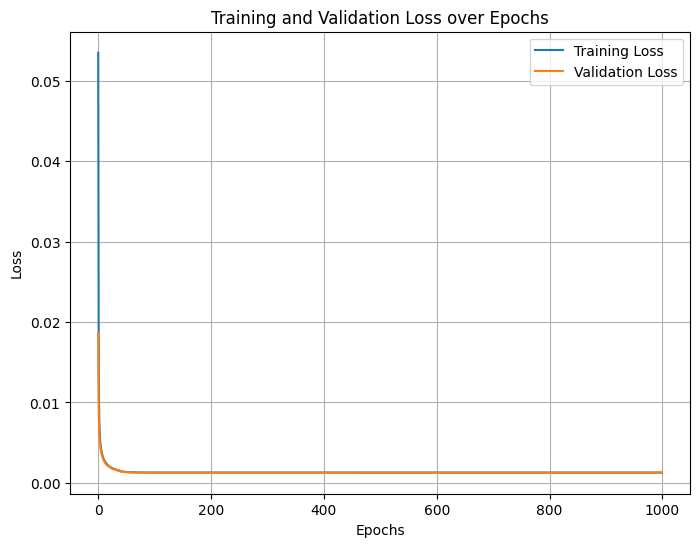

In [41]:
CAE_MNIST.plotLoss()

# Autoencoders on Animals Data

A much more challenging data set.

* Show the Animals
* Compare 1K epoch trainings

In [42]:
CAE_ANIMALS = ConvolutionalAutoencoder.deserialize(PATH_CAE_ANIMALS)

# Autoencoders and Noise Reduction

## Encoders and Decoders

In [43]:
cae_encoder = CAE_ANIMALS.encoder
cae_decoder = CAE_ANIMALS.decoder

Using encoder and decoder separately

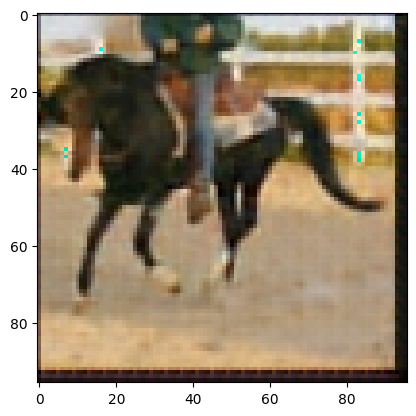

In [49]:
encodings = cae_encoder(X_ANIMALS_TEST[:2])
predictions = cae_decoder(encodings.detach().cpu().numpy())
plt.imshow(predictions[0].detach().cpu().numpy().astype(np.uint8))                       

Distortions

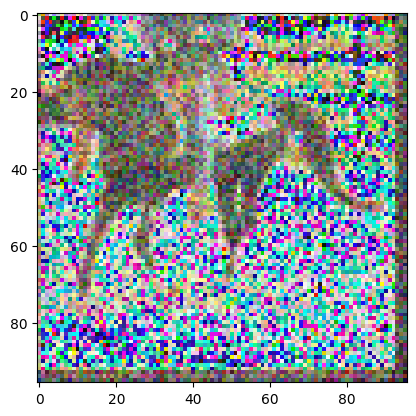

In [56]:
distortion_arr = (0.5*np.random.random(np.prod(ANIMALS_IMAGE_SHAPE))*255).astype(np.uint8)
distortion_arr = np.reshape(distortion_arr, ANIMALS_IMAGE_SHAPE)
distorted_image = predictions[0].detach().cpu().numpy().astype(np.uint8) + distortion_arr    
plt.imshow(distorted_image)          

In [52]:
#encodings[0].shape
shape = encodings[0].shape
count = np.prod(shape)
change = np.random.random(count)
change_arr = np.reshape(change, shape)

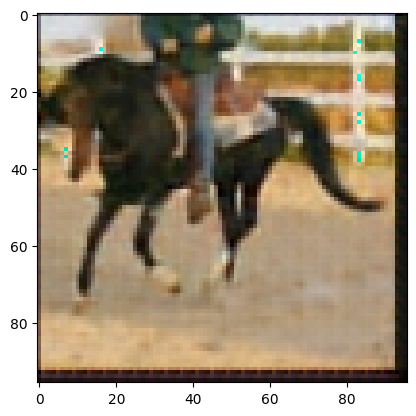

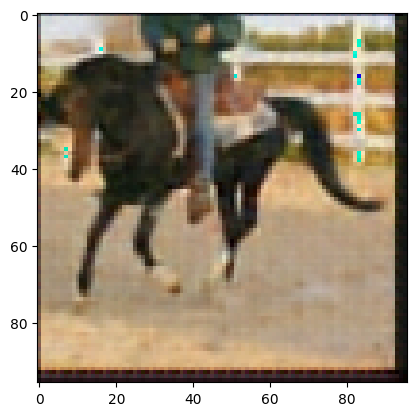

In [54]:
encodings = cae_encoder(X_ANIMALS_TEST[:2])
for x in [np.zeros(shape), 10*change_arr]:
    plt.figure()
    predictions = cae_decoder(encodings.detach().cpu().numpy() + x)
    plt.imshow(predictions[0].detach().cpu().numpy().astype(np.uint8))                       

# Other Topics

* Masked autoencoders
* Variational autoencoders
* Autoencoders and generative AI

# Notes

1. Do classification using encoded representation to reduce computation cost
2. Consider doing the autoencoding on the zip data
3. Tuning hyperparameters: batch size, number of epochs, activation (use same for each step?)
4. Using GPU
5. Debugging quality - what layers? what activations?
6. Choice of objective function.
7. Debugging layer shapes
8. Data preparation
9.   1. Normalize to create values between 0 and 1
10. Design
11.   1. Be consistent on the activations. If an encoder layer uses 'relu', the corresponding decoder layer should as well.
12. Tuning
13.  1. Need enough batches of sufficient size, approx 100. At least 30-40 batches
14.  2. Start with less compression and then go to more
15. Pro tips
    1. ``EarlyStopping``
    2. ``ReduceLROnPlateau``
    3. ``ModelCheckpoint`
16. Need
  1. Plot training and validation losses
  2. Convolutional MNIST